# Network training

For our project, we constructed a Vision Transformer (ViT) instance that we named `GlowDeTR` to assess how light exposure affects Neural Network's result at classification.

In [1]:
import torch
import json
import ast
import torch.nn as nn
import numpy as np
import albumentations
from math import floor
from tqdm import tqdm

from pathlib import Path
from PIL import Image, ImageDraw
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import YolosForObjectDetection, AutoModelForObjectDetection, AutoImageProcessor, TrainingArguments, Trainer
from datasets import load_dataset, Dataset, concatenate_datasets
from tenacity import retry, wait_fixed, stop_after_attempt

# huggingface-cli download yin30lei/day_and_night_traffic_lights --repo-type dataset --local-dir ./traffic_lights

In [2]:
# leopard photos
# wildlife_ds1 = load_dataset("yin30lei/wildlife-from-wildme", split="train[20:27%]", cache_dir=Path.cwd() / "wildlife", num_proc=2)
# hyena photos
# wildlife_ds2 = load_dataset("yin30lei/wildlife-from-wildme", split="train[:8%]", cache_dir=Path.cwd() / "wildlife", num_proc=2)

# Or split locally
wildlife_ds = load_dataset("SeaSponge/wildme_dataset", cache_dir=Path.cwd() / "yalu_dataset")

In [3]:
class GlowYolos(YolosForObjectDetection):
    def forward(self, pixel_values, labels=None, **kwargs):
        outputs = super().forward(pixel_values=pixel_values, **kwargs)
        loss = None
        
        if labels is not None:
            # Use the `common_step` to calculate loss
            loss = self.common_step(labels, outputs.logits, outputs.pred_boxes)
        
        return {"loss": loss, **outputs}


tensor2PIL = transforms.ToPILImage()

transform1 = albumentations.Compose(
    [
        # albumentations.HorizontalFlip(p=1.0),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.LongestMaxSize(max_size=600),
        albumentations.RandomBrightnessContrast(p=0.5),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

checkpoint = "facebook/detr-resnet-50"
device = "cuda" if torch.cuda.is_available else "cpu"

In [4]:
wildlife_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 370
    })
    validation: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 95
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 64
    })
})

In [5]:
# Two labels: leopard & hyenas
try:
    print(wildlife_ds["train"])    
    wildlife_train_ds = wildlife_ds["train"]
except Exception as e:
    print(f"Errored due to -> {e}")
    wildlife_train_ds = wildlife_ds
    del wildlife_ds

Dataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_rows: 370
})


In [7]:
def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["bbox"])):
        box = annotations["bbox"][i]
        class_idx = annotations["label"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        print(f"height -> {height} | width -> {width}")
        print(f"x1 -> {x1} | y1 -> {y1} | x2 -> {x2} | y2 -> {y2}")
        draw.rectangle((x1, y1, x2, y2), outline="red", width=6)
        draw.text((x1, y1), annotations["label"], fill="white", font_size=40)
    return image

height -> 1800 | width -> 2400
x1 -> 1411 | y1 -> 727 | x2 -> 1996 | y2 -> 1097


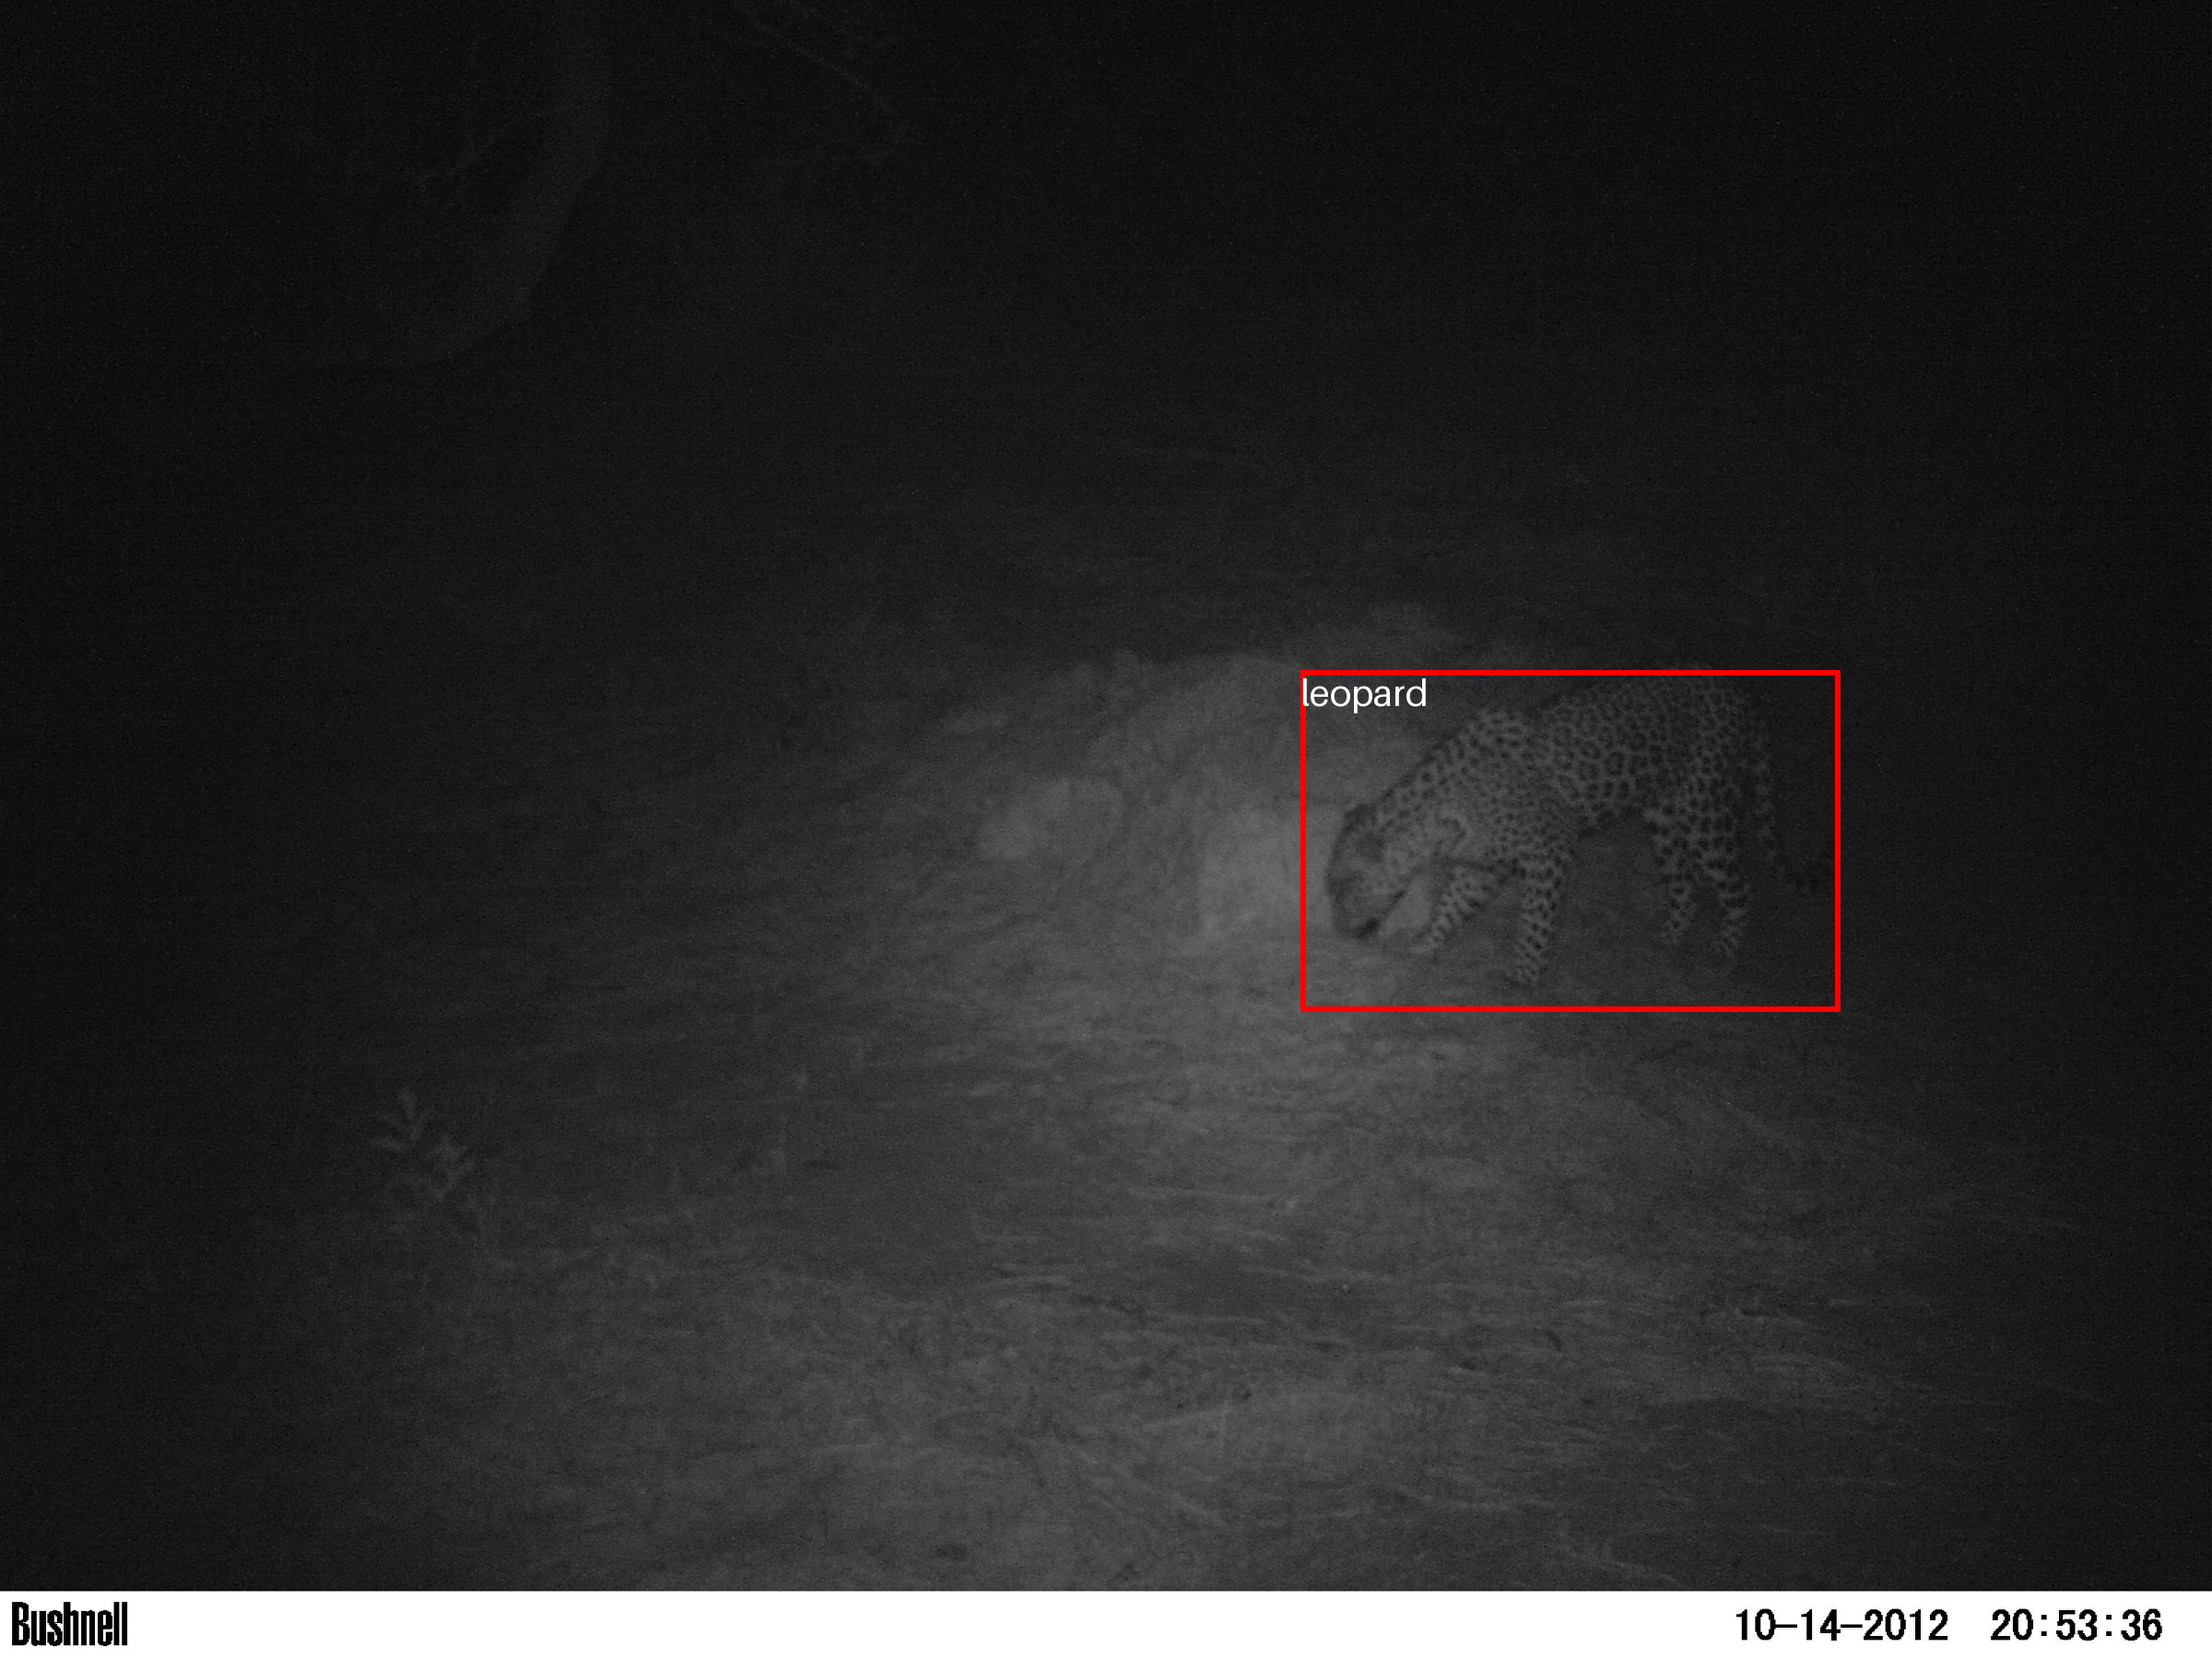

In [9]:
draw_image_from_idx(dataset=wildlife_train_ds, idx=200)

height -> 2400 | width -> 2045
x1 -> 0 | y1 -> 459 | x2 -> 1629 | y2 -> 1800
height -> 1800 | width -> 2400
x1 -> 3 | y1 -> 546 | x2 -> 698 | y2 -> 1515
height -> 2364 | width -> 2400
x1 -> 0 | y1 -> 106 | x2 -> 2350 | y2 -> 2229
height -> 1800 | width -> 2400
x1 -> 109 | y1 -> 830 | x2 -> 1337 | y2 -> 1710
height -> 1347 | width -> 2400
x1 -> 335 | y1 -> 838 | x2 -> 1688 | y2 -> 1338
height -> 1800 | width -> 2400
x1 -> 6 | y1 -> 682 | x2 -> 957 | y2 -> 1457
height -> 1800 | width -> 2400
x1 -> 642 | y1 -> 1186 | x2 -> 1487 | y2 -> 1735
height -> 2400 | width -> 2349
x1 -> 28 | y1 -> 57 | x2 -> 2284 | y2 -> 2240
height -> 1800 | width -> 2400
x1 -> 1253 | y1 -> 650 | x2 -> 2191 | y2 -> 1188


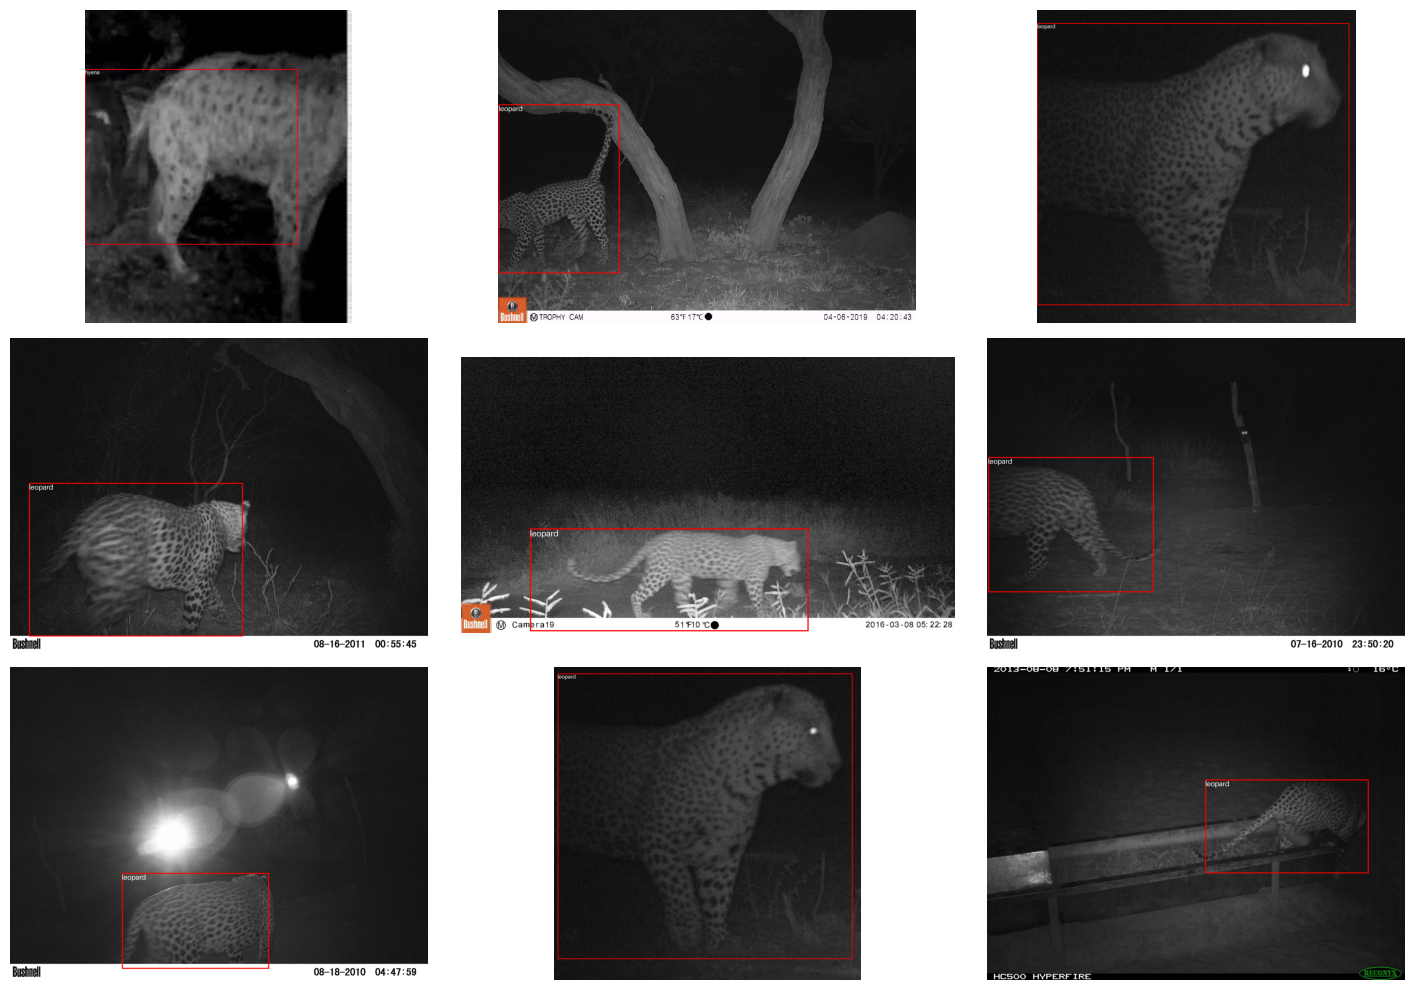

In [10]:
import matplotlib.pyplot as plt


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# Now use the function to plot images

plot_images(wildlife_train_ds, range(9))

In [11]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [12]:
image_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-small")

preprocessor_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

In [13]:
# transforming a batch

def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        #! category needs to be list, hence I put the extra brackets around it
        out = transform1(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [14]:
wildlife_train_ds_transformed = wildlife_train_ds.with_transform(transform_aug_ann)

In [15]:
wildlife_train_ds_transformed
del wildlife_train_ds

In [16]:
label2id = {"leopard" : 0, "hyena": 1}
id2label = {v:k for k, v in label2id.items()}

In [17]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

def collate_fn_yolo(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['labels'] = labels
    return batch

In [ ]:
# Define the training arguments

#! Too large
# checkpoint = "SenseTime/deformable-detr"

checkpoint = "hustvl/yolos-small"

model = YolosForObjectDetection.from_pretrained(checkpoint,
                                                id2label=id2label,
                                                label2id=label2id,
                                                ignore_mismatched_sizes=True)

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

#! From physical testing, batchsz=4 seems to be fine | 6364MiB / 11264MiB
#! update, I suppose batchsz=6 also works now. | 8534MiB / 11264MiB

# max_steps=3000 takes ~ 20 hours

training_args = TrainingArguments(
    output_dir="glow-model",
    per_device_train_batch_size=6,
    max_steps=1000,
    fp16=True,
    save_steps=10,
    logging_steps=30,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    lr_scheduler_type="cosine_with_restarts",  # Cosine scheduler with restarts
)


# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn_yolo,
    train_dataset=wildlife_train_ds_transformed,
    eval_dataset=None, #! unfortunately no test dataset yet
    tokenizer=image_processor,
)

trainer.train()
# saved_path = Path.cwd() / "results"
# trainer.save_model(saved_path)

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([3, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\yaluo\AppData\Local\Temp\ipykernel_40848\1631226257.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
max_steps is given, it will override any value given in num_train_epochs


  0%|          | 0/1000 [00:00<?, ?it/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
c:\Users\yaluo\anaconda3\envs\ml\lib\site-packages\transformers\models\yolos\modeling_yolos.py:326: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


{'loss': 6.0823, 'grad_norm': 80.45034790039062, 'learning_rate': 9.98579450130307e-06, 'epoch': 0.48}
{'loss': 2.9187, 'grad_norm': 8.576227188110352, 'learning_rate': 9.935960069974096e-06, 'epoch': 0.97}
{'loss': 2.4172, 'grad_norm': 229.6728515625, 'learning_rate': 9.842915805643156e-06, 'epoch': 1.45}
{'loss': 2.3332, 'grad_norm': 54.1617546081543, 'learning_rate': 9.704403844771128e-06, 'epoch': 1.94}
{'loss': 2.1673, 'grad_norm': 126.2717056274414, 'learning_rate': 9.530801051106449e-06, 'epoch': 2.42}
{'loss': 2.12, 'grad_norm': 14.043208122253418, 'learning_rate': 9.31168488778652e-06, 'epoch': 2.9}
{'loss': 2.0257, 'grad_norm': 32.48414993286133, 'learning_rate': 9.06347082216547e-06, 'epoch': 3.39}
{'loss': 1.9849, 'grad_norm': 62.018882751464844, 'learning_rate': 8.77125690368052e-06, 'epoch': 3.87}
{'loss': 2.0279, 'grad_norm': 48.244991302490234, 'learning_rate': 8.445569041936743e-06, 'epoch': 4.35}
{'loss': 1.9999, 'grad_norm': 200.16127014160156, 'learning_rate': 8.089